* Added Machine Translation
* Added User Interface using Gradio

# Patent Semantic Prior-art Search System
* Using Text Embedding AI models and a Vector Database (Chroma)
* Developed for educational purposes as an example of an AI system in the field of Intellectual Property.

# Introduction
* Developed by Gyudong HAN, Counsellor, WIPO  (gyudong.han@wipo.int)
* I developed this system with reference to the general [text retrieval system](https://colab.research.google.com/drive/1gyGZn_LZNrYXYXa-pltFExbptIe7DAPe?usp=sharing) which was uploaded together with the [video clip](https://www.youtube.com/watch?v=3yPBVii7Ct0) named "LangChain Retrieval QA Over Multiple Files with ChromaDB".
* But I changed almost everything. I changed the input data from general text data to patent title, abstract and claims. I used the same Vector Database (Chroma) but changed interface with reference to the [langchain chroma database manual](https://python.langchain.com/docs/integrations/vectorstores/chroma). I also changed the text embedding model from OpenAI to free open-source models according to the [langchain text embedding model's manual](https://python.langchain.com/docs/integrations/text_embedding/sentence_transformers).
* The patents are data of the United States of America downloaded from the [data portal of USPTO](https://bulkdata.uspto.gov/), United States Patent and Trademark Office.

# How this search system works
* (Step 1) Convert titles, abstracts and claims of patent documents filed already into vectors (a set of numbers). Each vector can be represented as a point on a coordinate space. The converted vectors are stored in vector databases such as title vector database, abstract vector database and claims vector database.
* (Step 2) Convert the query text into a vector.
* (Step 3) Try to find similar texts by comparing the vectors. Similar texts are the nearby texts in the coordinate space. Texts can be compared with title, abstract or claims.
* You can find the principle of this pilot system [here](https://drive.google.com/file/d/1BQZJR3qMecOWNJprM0c6Uy13WSSzniwP/view?usp=sharing).


# How to execute
* At first, click the "Copy to Drive" button above to copy this program to your Google Drive. (You need google account.) Then you can execute it.
* You need to run each cell. Put mouse over 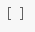, it will change like this: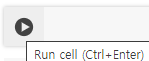. Then, click the icon. The code of the cell will be executed and you can see the result right away.
* Like this, you can run each cell one by one and can see the results.


# Program Structure
* Installing necessary libraries
* Copy patent data of USA from USPTO data portal
* Split the combined XML into separate XMLs
* Extract title, abstract, claims, etc from splited XMLs
* Load Text Embedding Model
* Checking the embedding value of a sample text
* Create Chroma Vector DB and store text embedding vectors in the DB
* Test the system by querying texts to find similar patents

# Installing necessary libraries

In [ ]:
# install libraries
!pip -q install langchain chromadb langchain-chroma sentence-transformers

# Copy patent data of USA from USPTO data portal
  - Copy a zipped file and unzip it.

In [ ]:
# Copy an US patent application file from USPTO (Patent application data in January 21, 2021)
!wget  https://bulkdata.uspto.gov/data/patent/application/redbook/fulltext/2021/ipa210121.zip
!unzip "ipa210121.zip"

--2024-04-25 05:14:46--  https://bulkdata.uspto.gov/data/patent/application/redbook/fulltext/2021/ipa210121.zip
Resolving bulkdata.uspto.gov (bulkdata.uspto.gov)... 151.207.245.28, 2610:20:5011:1604::28
Connecting to bulkdata.uspto.gov (bulkdata.uspto.gov)|151.207.245.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146902825 (140M) [application/zip]
Saving to: ‘ipa210121.zip’

ipa210121.zip       100%[===================>] 140.10M  6.79MB/s    in 21s     

2024-04-25 05:15:07 (6.71 MB/s) - ‘ipa210121.zip’ saved [146902825/146902825]

Archive:  ipa210121.zip
  inflating: ipa210121.xml           


In [ ]:
INPUT_FILENAME = "ipa210121.xml" # extracted file

# Split the combined XML into separate XMLs
* USPTO's patent file distributed online daily is composed of a lot of patent application XMLs. So we need to split it into separate XMLs.
* The combined XML has two kinds of xmls. One is a general PATENT application and the other is a SEQUENCE application.
* Example of a combined XML: the following file has two patent applications and one sequence application. We will use only the patent applications. (We will not use the sequence applications.)
```
<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE us-patent-application SYSTEM "us-patent-application
...
r member are in contact with the substrate.</claim-text>
</claim>
</claims>
</us-patent-application>
<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE us-patent-application SYSTEM "us-patent-applicatio
...
ube comprises a window in the main portion.</claim-text>
</claim>
</claims>
</us-patent-application>
<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE sequence-cwu SYSTEM "us-sequence-listing.dtd" [ ]>
...
                                                              64
</s400>
</sequence-list-new-rules>
```



In [ ]:
# Define a function to split the combined XML file into separate XML files

import re

def split_xml(input_filename, pat_end_tag, seq_end_tag):
    try:
        # Read the XML file and store its content
        with open(input_filename, 'r', encoding='utf-8') as input_file:
            xml_data = input_file.read()

        # Define the regular expression pattern
        # to match end tag of patent application xml OR end tag of sequence xml
        pattern = f'{pat_end_tag}|{seq_end_tag}'

        # Split the content based on the pattern
        splited_xmls = re.split(pattern, xml_data)

        return splited_xmls

    except Exception as e:
        print("Error:", str(e))

In [ ]:
# Split combined xml into PATENT-xmls and SEQUENCE-xmls

input_filename = INPUT_FILENAME
pat_end_tag = '</us-patent-application>'
seq_end_tag = '</sequence-cwu>'
# sequence xml starts with
# '<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE sequence-cwu SYSTEM "'
# patent application xml starts with
# '<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE us-patent-application'

original_splited_xmls = split_xml(input_filename, pat_end_tag, seq_end_tag)

del original_splited_xmls[-1] # delete the last xml because it is only '\n'


pat_splited_xmls = [] # list of splited patent-xmls
seq_splited_xmls = [] # list of splited sequence-xmls

for i, xml in enumerate(original_splited_xmls):
  if xml[:100].count("sequence-cwu") >= 1: # sequence xml
    seq_splited_xmls.append(xml)
  elif xml[:100].count("us-patent-application") >= 1: # patent application xml
    pat_splited_xmls.append(xml)
  else:  # Output error message
    print("There is other types of xml files rather than sequence or application in index ", i)
    print(xml)

# CAUTION: the end_tag was deleted when splited
# So need to add end_tag to each separated xml

for i in range(len(pat_splited_xmls)):
  pat_splited_xmls[i] += pat_end_tag

print("Total number of the splited XMLs: ", len(original_splited_xmls))
print("patent application xmls: ", len(pat_splited_xmls), " / sequence xmls: ", len(seq_splited_xmls))

Total number of the splited XMLs:  7493
patent application xmls:  7262  / sequence xmls:  231


In [ ]:
# Print out splited PATENT application xmls

pat_splited_xmls_count = len(pat_splited_xmls)

# Print out the splited parts.
# Print only front 20 and back 20 if the number of splited part exceeds 40
# Otherwise print out all the xml files

print("Splited PATENT application xmls:")
if pat_splited_xmls_count <= 40:
  for i in range(pat_splited_xmls_count):
    print("\n\nSplited part ", i)
    print(pat_splited_xmls[i][:100])
    print("...")
    print(pat_splited_xmls[i][-100:])
else: # pat_splited_xmls_count > 40
  for i in range(20):
    print("\n\nSplited part ", i)
    print(pat_splited_xmls[i][:100])
    print("...")
    print(pat_splited_xmls[i][-100:])
  for i in range(20):
    print("\n\nSplited part ", pat_splited_xmls_count - 19 + i)
    print(pat_splited_xmls[pat_splited_xmls_count - 20 + i][:100])
    print("...")
    print(pat_splited_xmls[pat_splited_xmls_count - 20 + i][-100:])

Splited PATENT application xmls:


Splited part  0
<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE us-patent-application SYSTEM "us-patent-application
...
r member are in contact with the substrate.</claim-text>
</claim>
</claims>
</us-patent-application>


Splited part  1

<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE us-patent-application SYSTEM "us-patent-applicatio
...
ube comprises a window in the main portion.</claim-text>
</claim>
</claims>
</us-patent-application>


Splited part  2

<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE us-patent-application SYSTEM "us-patent-applicatio
...
g attachment over and/or through said soil.</claim-text>
</claim>
</claims>
</us-patent-application>


Splited part  3

<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE us-patent-application SYSTEM "us-patent-applicatio
...
 pins to secure the plow to the plow mount.</claim-text>
</claim>
</claims>
</us-patent-application>


Splited part  4

<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE us-

In [ ]:
# Print out splited SEQUENCE xmls

seq_splited_xmls_count = len(seq_splited_xmls)

# Print out the splited parts.
# Print only front 2 and back 2 if the number of splited part exceeds 4
# Otherwise print out all the xml files

print("Splited SEQUENCE xmls:")
if seq_splited_xmls_count <= 4:
  for i in range(seq_splited_xmls_count):
    print("\n\nSplited part ", i)
    print(seq_splited_xmls[i][:100])
    print("...")
    print(seq_splited_xmls[i][-100:])
else: # seq_splited_xmls_count > 4
  for i in range(2):
    print("\n\nSplited part ", i)
    print(seq_splited_xmls[i][:100])
    print("...")
    print(seq_splited_xmls[i][-100:])
  for i in range(2):
    print("\n\nSplited part ", seq_splited_xmls_count - 1 + i)
    print(seq_splited_xmls[seq_splited_xmls_count - 2 + i][:100])
    print("...")
    print(seq_splited_xmls[seq_splited_xmls_count - 2 + i][-100:])

Splited SEQUENCE xmls:


Splited part  0

<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE sequence-cwu SYSTEM "us-sequence-listing.dtd" [ ]>
...
                                                              64
</s400>
</sequence-list-new-rules>



Splited part  1

<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE sequence-cwu SYSTEM "us-sequence-listing.dtd" [ ]>
...
tg ccgaacggac gac                                             23
</s400>
</sequence-list-new-rules>



Splited part  230

<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE sequence-cwu SYSTEM "us-sequence-listing.dtd" [ ]>
...

<row>
<entry namest="1" nameend="1" align="center" rowsep="1"/>
</row>
</tbody>
</tgroup>
</table>



Splited part  231

<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE sequence-cwu SYSTEM "us-sequence-listing.dtd" [ ]>
...
p Gly
1               5                   10                  15
</s400>
</sequence-list-new-rules>



# Extract title, abstract, claims, etc from splited XMLs
* Make Document formats with the extracted texts
* USE only the PATENT application xmls, NOT use the SEQUENCE xmls.

In [ ]:
# define a function to extract infos from each splited XML files
# infos such as application, publication, title, abstract, claims

import xml.etree.ElementTree as ET

def extract_info_from_one_xml(input_xml):
  try:
    root = ET.fromstring(input_xml.lstrip('\n'))
    # The file must start with '<?xml version="1.0" encoding="UTF-8"?>'.
    # An error occurs if page_content starts with '\n'.
    # Therefore, delete the first newline character ('\n').

    # Continue processing the parsed XML as needed
  except ET.ParseError as e:
    # Handle the XML parsing error
    print("XML Parsing Error:", e)
    # Optionally, log the error or take corrective actions

  # Extract <doc-number> from <publication-reference>
  publication_reference = root.find(".//publication-reference")
  doc_number_publication = publication_reference.find(".//doc-number").text
  doc_date_publication = publication_reference.find(".//date").text

  # Extract <doc-number> from <application-reference>
  application_reference = root.find(".//application-reference")
  doc_number_application = application_reference.find(".//doc-number").text
  doc_date_application = application_reference.find(".//date").text

  # Extract <invention-title>
  invention_title = root.find(".//invention-title").text

  # Extract <abstract>
  abstract_element = root.find(".//abstract")
  abstract = ET.tostring(abstract_element, encoding="utf-8", method="text").decode("utf-8") if abstract_element is not None else ""

  # Extract <claims>
  # Document's page_content's type of Chroma DB is str
  claims = ""
  xml_claims = root.find('claims')
  for claim in xml_claims.findall('claim'):
      claim_text = ''.join(claim.find('claim-text').itertext())
      claim_text = claim_text.strip('\n')
      claims += claim_text

  return doc_number_application, doc_date_application, \
         doc_number_publication, doc_date_publication, \
         invention_title, abstract, claims

### Make a special Document format to use langchain's Chroma interface
* To create a Chroma Database through the langchain's function "Chroma.from_documents", we need a special document format.
* The Document is composed of page_content and metadata: Document(page_content='Combination Digging Device and Head Rest', metadata={'application_number': '16684704', 'application_date': '20191115'})

In [ ]:
# Make langchain Documents with extracted patent title, abstract, pub_num, app_num
# Make three different Documents with title, abstract, and claims
# Target format is a list like this:
# [Document(page_content='Combination Digging Device and Head Rest', metadata={'application_number': '16684704', 'application_date': '20191115'}),
#  Document(page_content='WEED REMOVER', metadata={'application_number': '16922605', 'application_date': '20200707'}), ...]

from langchain.schema import document

# Create a title documents with patent titles
title_documents = []
abstract_documents = []
claims_documents = []
patent_documents = []

# store SOME XMLs in the Document for faster execution of this pilot program
# The splited XMLs are stored in pat_splited_xmls
for i, pat_splited_xml in enumerate(pat_splited_xmls):
  if i > 1000:
    break
  app_num, app_date, pub_num, pub_date, title, abstract, claims = extract_info_from_one_xml(pat_splited_xml)

  new_title_document = document.Document(page_content=title, metadata={'application_number': app_num, 'application_date': app_date})
  title_documents.append(new_title_document)
  new_abstract_document = document.Document(page_content=abstract, metadata={'application_number': app_num, 'application_date': app_date})
  abstract_documents.append(new_abstract_document)
  new_claims_document = document.Document(page_content=claims, metadata={'application_number': app_num, 'application_date': app_date})
  claims_documents.append(new_claims_document)

  new_patent_document = document.Document(page_content=pub_date, metadata={'application_number': app_num, 'application_date': app_date, 'title': title, 'abstract': abstract, 'claims': claims})
  patent_documents.append(new_patent_document)


### Check the created title Document, abstract Document, and claims Document

In [ ]:
print("titles: ", len(title_documents))
print("abstract: ", len(abstract_documents))
print("claims: ", len(claims_documents))

In [ ]:
print("patents: ", len(patent_documents))

In [ ]:
title_documents

In [ ]:
abstract_documents

In [ ]:
patent_documents

# Load Text Embedding Model
* Text Embedding model converts a text into a vector, a set of numbers.
* The vector has the characteristics of the text.
* Below, We will use two (free) text embedding models
  - [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) for embedding dimension 384, whose ranking is 61 in the [MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard) (as of Feb. 2, 2024)
  - [llmrails/ember-v1](https://huggingface.co/llmrails/ember-v1) for embedding dimension 1024, whose ranking is 12 in the [MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard) (as of Feb. 2, 2024)
* By default, we use the AI model for embedding dimension 384. But you can use 1024 dimension model for a better performance.
* You can also use other embedding AI models such as OpenAI's model which is not a free model. You can find more information [here](https://python.langchain.com/docs/integrations/vectorstores/chroma).
* More information can be found in langchain's [chroma](https://python.langchain.com/docs/integrations/vectorstores/chroma) or [sentence_transformers](https://python.langchain.com/docs/integrations/text_embedding/sentence_transformers) guide.

In [ ]:
# load text embedding models
from langchain_community.embeddings import HuggingFaceEmbeddings

#embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2") # embedding dimension 384
embedding_function = HuggingFaceEmbeddings(model_name="llmrails/ember-v1") # embedding dimension 1024

# Checking the embedding value of a sample text

In [ ]:
# Let's check the embedding value for the first patent application's abstract

import textwrap

# Calculate the embedding value
embeddings = embedding_function.embed_query(abstract_documents[0].page_content)

# print out the embedding values
numbers_in_a_row = 8
for embedding in embeddings:
  for i in range(numbers_in_a_row):
    print(embedding, end=", ")
  print()

print("\n Above is the embedding of the first patent application's abstract below:")
print('\n'.join(textwrap.wrap(abstract_documents[0].page_content, 150)))

print("\nDimension of the embedding is ", len(embeddings))

# Create Chroma Vector DB and store text embedding vectors in the DB
* You can find more information about how to create Chroma database [here](https://python.langchain.com/docs/integrations/vectorstores/chroma).
* When you create the same collection again, at first you need to delete the existing one by:
  - title_db.delete_collection()
  - abstract_db.delete_collection()
  - claims_db.delete_collection()
* We can choose "l2", "ip, "or "cosine". The default is "l2" which is the squared L2 norm. 'cosine' is cosine similarity. 'ip' is Inner Product. More general information can be found [here](https://docs.trychroma.com/usage-guide) and "from_documents" options [here](https://api.python.langchain.com/en/latest/vectorstores/langchain_community.vectorstores.chroma.Chroma.html).
 - We can use this option for "Chroma.from_documents" like this: Chroma.from_documents(...,collection_metadata={"hnsw:space": "cosine"})

In [ ]:
from langchain_chroma import Chroma

### Make three different databases with title, abstract and claims
* The database will be stored in memory.

In [ ]:
# Create TITLE Chroma DB
title_db = Chroma.from_documents(
                           collection_name = "US_patent_application_TITLE_DB",
                           documents = title_documents,
                           embedding = embedding_function,
                          )

In [ ]:
# Create ABSTRACT Chroma DB
abstract_db = Chroma.from_documents(
                           collection_name = "US_patent_application_ABSTRACT_DB",
                           documents = abstract_documents,
                           embedding = embedding_function,
                          )

In [ ]:
# Create CLAIMS Chroma DB
claims_db = Chroma.from_documents(
                           collection_name = "US_patent_application_CLAIMS_DB",
                           documents = claims_documents,
                           embedding = embedding_function,
                          )

In [ ]:
##upd1
patent_db = Chroma.from_documents(
                            collection_name = "US_patent_application_PATENTS_DB",
                            documents = patent_documents,
                            embedding = embedding_function,
)

# Test the system by querying texts to find similar patents
* basic query: title_db.similarity_search_with_score(query, 10)
 - It will give 10 similar patent documents.
* query with similarity score: title_db.similarity_search_with_score(query, 10)
 - It will give 10 results with similarity scores.
* You can find more information about the query function [here](https://api.python.langchain.com/en/latest/vectorstores/langchain_community.vectorstores.xata.XataVectorStore.html).

In [ ]:
# query to TITLE DB with score
query = "plant cutting machine"
results = title_db.similarity_search_with_score(query, 10)

results

In [ ]:
# query to ABSTRACT DB with score
query = "lawn trimming tool"
results = abstract_db.similarity_search_with_score(query, 10)

results

In [ ]:
# query to CLAIMS DB with score
query = "lawn trimming tool"
results = claims_db.similarity_search_with_score(query, 10)

results

In [ ]:
query = "humidity and temperature control system automation"
results = patent_db.similarity_search_with_score(query, 10)

results

[(Document(page_content='20210121', metadata={'abstract': '\nAn orthopedic device for supporting a lower back of a user includes a mechanical energy store, a pelvic element, an upper body element with a first force transmission element and an upper leg element with a second force transmission element. The upper leg element is arranged on the pelvic element such that it can be swivelled about a first swivel axis, the upper body element is movably arranged relative to the pelvic element, the first force transmission element can be engaged and disengaged with the second force transmission element by moving the upper body element relative to the pelvic element, and the mechanical energy store can be charged and discharged by swivelling the upper leg element relative to the upper body element when the first force transmission element is engaged with the second force transmission element.\n\n', 'application_date': '20200717', 'application_number': '16947088', 'claims': '1. An orthopedic devi

### Query with a patented document's title, abstract, and claims.

In [ ]:
# US11096325B2, 2017-12-28 Application filed by LG Electronics Inc from google patent

LGpat_title = "Lawn mower robot"

LGpat_abstract = "A lawn mower robot includes an inner body provided with casters and wheels for moving, a plurality of blades rotatably provided on a bottom surface of the inner body to cut grass, a drive motor mounted on the wheels, respectively, to independently drive the wheels, and an outer cover mounted on and configured to surround an outer side of the inner body to be movable in forward, backward, leftward and rightward directions with respect to the inner body when colliding with an obstacle. A plurality of ultrasonic sensors are provided to sense an obstacle, and an ultrasonic guide unit is formed to be recessed rearward from a front end portion of the outer cover so as to restrict a downward propagation angle of ultrasonic waves generated from the ultrasonic sensors."

LGpat_claim_1 = """1. A lawn mower robot, comprising:
an inner body provided with casters near a front side of the inner body and wheels near a rear side of the inner body;
a plurality of blades rotatably provided on a bottom surface of the inner body to cut grass;
a drive motor mounted on each of the wheels to independently drive the wheels;
an outer cover configured to surround the inner body and mounted on the inner body to be movable relative to the inner body, the outer cover being configured to move forward, backward, left and right with respect to the inner body when the outer cover of the lawn mover robot collides with an obstacle; and
support portions provided at front and rear upper portions of the inner body, to elastically support the outer cover,
wherein the support portions include:
a support portion body coupled to the outer cover and made of an elastic material to elastically support the outer cover; and
a plurality of curved portions coupled to an outer circumferential surface of the support portion body and curved along a radial direction from the support portion body to support the support portion body so as to be movable in lateral and vertical directions,
wherein the plurality of curved portions are aligned in the radial direction along an outer circumferential surface of the support portion body."""

LGpat_claim = """1. A lawn mower robot, comprising:
an inner body provided with casters near a front side of the inner body and wheels near a rear side of the inner body;
a plurality of blades rotatably provided on a bottom surface of the inner body to cut grass;
a drive motor mounted on each of the wheels to independently drive the wheels;
an outer cover configured to surround the inner body and mounted on the inner body to be movable relative to the inner body, the outer cover being configured to move forward, backward, left and right with respect to the inner body when the outer cover of the lawn mover robot collides with an obstacle; and
support portions provided at front and rear upper portions of the inner body, to elastically support the outer cover,
wherein the support portions include:
a support portion body coupled to the outer cover and made of an elastic material to elastically support the outer cover; and
a plurality of curved portions coupled to an outer circumferential surface of the support portion body and curved along a radial direction from the support portion body to support the support portion body so as to be movable in lateral and vertical directions,
wherein the plurality of curved portions are aligned in the radial direction along an outer circumferential surface of the support portion body.
2. The lawn mower robot of claim 1, further comprising:
a plurality of ultrasonic sensors provided at a front side of the outer cover to sense an obstacle in front of the lawn mower robot; and
an ultrasonic guide unit formed on the outer cover and configured to restrict a downward propagation angle of ultrasonic waves generated from the ultrasonic sensors.
3. The lawn mower robot of claim 2, wherein the ultrasonic guide unit includes:
a lateral surface provided at a predetermined height above an upper end of a front end portion of the outer cover and extending from the front end of the outer cover toward a rear end of the outer cover;
a mounting surface provided a prescribed distance from the front end portion of the outer cover and extending upward from the lateral surface, wherein the plurality of ultrasonic sensors are embedded in the mounting surface; and
a side surface formed at both lateral sides of the mounting surface and angled laterally.
4. The lawn mower robot of claim 3, wherein the lateral surface is angled relative to the ground such that a propagation angle of the ultrasonic waves in a vertical direction is greater than a prescribed minimum angle to restrict downward propagation of the ultrasonic waves.
5. The lawn mower robot of claim 3, wherein the plurality of ultrasonic sensors are spaced apart from each other along the mounting surface.
6. The lawn mower robot of claim 2, further comprising:
a control unit configured to control the drive motors according to a signal sensed from the plurality of ultrasonic sensors to reduce a driving speed of the wheels.
7. The lawn mower robot of claim 1, further comprising:
a height adjusting lever rotatably mounted on the upper portion of the inner body to adjust a height of the blade;
a first opening formed at an upper portion of the outer cover in communication with the height adjusting lever; and
a first cover that is hinge-coupled to the outer cover to open and close the first opening.
8. The lawn mower robot of claim 7, further comprising:
a display and a keypad provided at a rear upper portion of the inner body;
a second opening formed at a rear upper portion of the outer cover in communication with the display and the keypad; and
a second cover that is hinge-coupled to the outer cover to open and close the second opening.
9. The lawn mower robot of claim 8, further comprising:
an emergency stop switch disposed between the first cover and the second cover, the emergency stop switch being mounted on the outer cover and configured to be pressed in an emergency to stop the wheels.
10. The lawn mower robot of claim 1, further comprising:
a carry handle, both sides of which extend in an upwardly inclined manner from an upper front side of side surfaces of the outer cover to a rear side of the outer cover to protrude toward a rear upper portion of the outer cover, and having a rear end portion which is formed in a closed curved surface shape.
11. The lawn mower robot of claim 1, further comprising charging terminals for charging a battery are provided at an upper portion of one side of the outer cover.
12. The lawn mower robot of claim 1, further comprising IR receiving windows and IR sensors configured to sense a charging stand, the IR receiving windows being provided on front and rear surfaces of the outer cover, wherein the IR receiving window provided on the front surface of the outer cover is disposed at a position closer to the charging stand with respect to a longitudinal center line of the outer cover than the IR receiving window provided on the rear surface.
13. The lawn mower robot of claim 1, further comprising:
a joystick bumper provided on the inner body to be rotatable in all directions, wherein an upper side of the joystick bumper is coupled to the outer cover and a sensing unit configured to sense collisions between the outer cover and an obstacle is provided at a lower side of the joystick bumper.
14. The lawn mower robot of claim 13, wherein the joystick bumper includes:
a bumper body formed in a rod-shaped structure disposed to extend in a vertical direction;
a joint protrusion portion that protrudes from an intermediate portion of the bumper body and configured to allow movement of the upper side of the bumper body in lateral directions with respect to the inner body and mounted on a joint bumper mounting portion within the inner body; and
a spring having one side coupled to the joint bumper mounting portion within inner body and another side mounted on the bumper body to extend downward from the joint protrusion portion and configured to return the bumper body to an original position.
15. The lawn mower robot of claim 14, wherein the sensing unit includes a magnet provided on a bottom end of the bumper body and a hall sensor provided within the inner body and configured to sense a collision between the outer cover and an obstacle by interaction with the magnet.
16. The lawn mower robot of claim 15, wherein when the bumper body is in the original position, the magnet is positioned over the hall sensor, and when the bumper body is moved from the original position, the magnet is moved away from the hall sensor and the wheels are controlled to stop rotating.
17. The lawn mower robot of claim 13, wherein the joystick bumper includes an elastic member having an upper end portion coupled to an upper portion of the joystick bumper to surround the joystick bumper, and a lower end portion coupled to the inner body to elastically support the joystick bumper, wherein the elastic member is formed in a bellows shape in which a width of the elastic member gradually decreases in an upward direction.
18. The lawn mower robot of claim 1, further comprising:
a battery mounted within the inner body; and
a display and a keypad mounted on an upper rear side of the inner body.
19. A lawn mower robot, comprising:
an inner body;
an outer body to cover the inner body;
support portions provided at front and rear upper portions of the inner body to elastically support the outer body,
casters provided near a front side of the inner body;
wheels provided near a rear side of the inner body;
a plurality of blades rotatably provided on a bottom surface of the inner body to cut grass;
a plurality of drive motors that drive the wheels and the blades;
a plurality of sensors configured to sense an obstacle in a path of the lawn mower robot, to sense a collision between the outer body and the obstacle, and to sense a position of a charging station relative to the lawn mower robot; and
a controller to automatically control the wheels and the blades to stop rotating based on sensed information from the plurality of sensors, wherein the support portions include:
a support portion body coupled to the outer body and made of an elastic material to elastically support the outer body; and
a plurality of curved portions coupled to an outer circumferential surface of the support portion body and curved along a radial direction from the support portion body to support the support portion body so as to be movable in lateral and vertical directions,
wherein the plurality of curved portions are aligned in the radial direction on an outer circumferential surface of the support portion body.
20. The law mower robot of claim 1, wherein the plurality of curved portions form an accordion shape."""


In [ ]:
# query to TITLE DB with score
query = LGpat_title
results = title_db.similarity_search_with_score(query, 10)

results

In [ ]:
query = LGpat_abstract
results = abstract_db.similarity_search_with_score(query, 10)

results

In [ ]:
# query the WHOLE claims of LG patent to CLAIMS DB with score
query = LGpat_claim
results = claims_db.similarity_search_with_score(query, 10)

results

In [ ]:
# query the first claim of LG patent to CLAIMS DB with score
query = LGpat_claim_1
results = claims_db.similarity_search_with_score(query, 10)

results

### Query by METADATA

In [ ]:
# query by application number
import textwrap

meta_query = {'application_number': '17043261'}

results_title = title_db.get(where=meta_query)
results_abstract = abstract_db.get(where=meta_query)
results_claims = claims_db.get(where=meta_query)

print("Results for", meta_query)
print("Application Date : ", results_title["metadatas"][0]["application_date"])
print("Title : ", results_title["documents"][0])
print("Abstract : ", results_abstract["documents"][0])
print("Claims : ", '\n'.join(textwrap.wrap(results_claims["documents"][0], 200)))

### Machine Translation
* You can find more information from [here](https://learn.deeplearning.ai/courses/open-source-models-hugging-face/lesson/4/translation-and-summarization)
* To choose other languages, you can find the other language codes on the page: [Languages in FLORES-200](https://github.com/facebookresearch/flores/blob/main/flores200/README.md#languages-in-flores-200)
  - Tagalog	tgl_Latn

In [ ]:
# Libraries for Machine Translation

!pip install transformers
!pip install torch

In [ ]:
# code that suppresses warning messages

from transformers.utils import logging
logging.set_verbosity_error()

In [ ]:
from transformers import pipeline

In [ ]:
translator = pipeline(task="translation",
                      model="facebook/nllb-200-distilled-600M")

In [ ]:
query = "lawn trimming tool"
results = abstract_db.similarity_search_with_score(query, 10)

results

In [ ]:
text = results[0][0].page_content
text_translated = translator(text,
                             src_lang="eng_Latn",  # from english
                             tgt_lang="kor_Hang")  # to Korean

In [ ]:
print("Source: ", text)
print("Translated: ", text_translated[0]['translation_text'])

### Adding user interface

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

In [ ]:
# For query for text
# https://www.gradio.app/guides/quickstart

def greet(query):
    results = abstract_db.similarity_search_with_score(query, 10)
    return results

demo = gr.Interface(
    fn=greet,
    inputs=gr.Textbox(lines=2, placeholder="input query text"),
    outputs="text"
)

demo.launch()

# gradio ui



In [ ]:
! pip install gradio
! pip install tabulate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.8 MB/s et

In [ ]:
import gradio as gr
from tabulate import tabulate

In [ ]:
def patent(query):
    results = patent_db.similarity_search_with_score(query, 10)

    # Prepare the table data from the results
    table_data = []
    for result in results:
        document = result[0]
        score = result[1]
        application_number = document.metadata['application_number']
        application_date = document.metadata['application_date']
        title = document.metadata['title']
        abstract = document.metadata['abstract']
        claims = document.metadata['claims']

        table_data.append((application_number, application_date, title, abstract, claims))

    headers = ["Application Number", "Application Date", "Title", "Abstract", "Claims", 'Score']

    formatted_table = tabulate(table_data, headers=headers, tablefmt="html")

    return formatted_table

demo = gr.Interface(
    fn=patent,
    inputs=gr.Textbox(lines=1, placeholder="Input query text"),
    outputs="html"
)

demo.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://755c287e2036296a91.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
